Raw path: /kaggle/input/brain-tumor-mri-dataset
Data root: /kaggle/input/brain-tumor-mri-dataset
Train classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Test classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Train dir: /kaggle/input/brain-tumor-mri-dataset/Training
Test dir: /kaggle/input/brain-tumor-mri-dataset/Testing


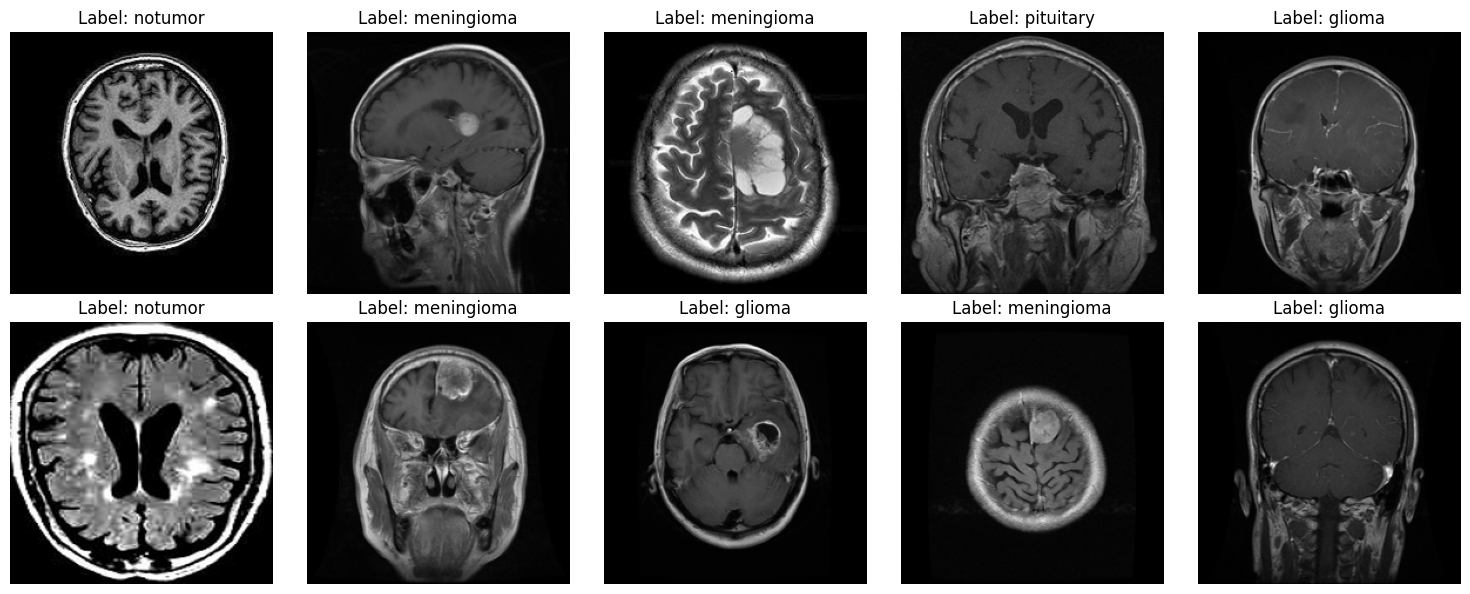

Class weights: {np.int64(0): np.float64(1.080999242997729), np.int64(1): np.float64(1.0664675130694548), np.int64(2): np.float64(0.8952978056426333), np.int64(3): np.float64(0.9800960878517502)}
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 139s 536ms/step - accuracy: 0.6186 - loss: 0.9088 - val_accuracy: 0.7649 - val_loss: 0.6060 - learning_rate: 1.0000e-04
Epoch 2/20
  1/228 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.9500 - loss: 0.1257

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9500 - loss: 0.1257 - val_accuracy: 0.7588 - val_loss: 0.6547 - learning_rate: 1.0000e-04
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 142s 623ms/step - accuracy: 0.8765 - loss: 0.3452 - val_accuracy: 0.8395 - val_loss: 0.4800 - learning_rate: 1.0000e-04
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8500 - loss: 0.3511 - val_accuracy: 0.8386 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 133s 409ms/step - accuracy: 0.9133 - loss: 0.2572 - val_accuracy: 0.8404 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 1.0000 - loss: 0.0686 - val_accuracy: 0.8289 - val_loss: 0.4864 - learning_rate: 1.0000e-04
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 122s 416ms/step - accuracy: 0.9238 - loss: 0.2304 - val_accuracy: 0.8500 - val_loss: 0.4077 - learning_rate: 1.0000e-04
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - a

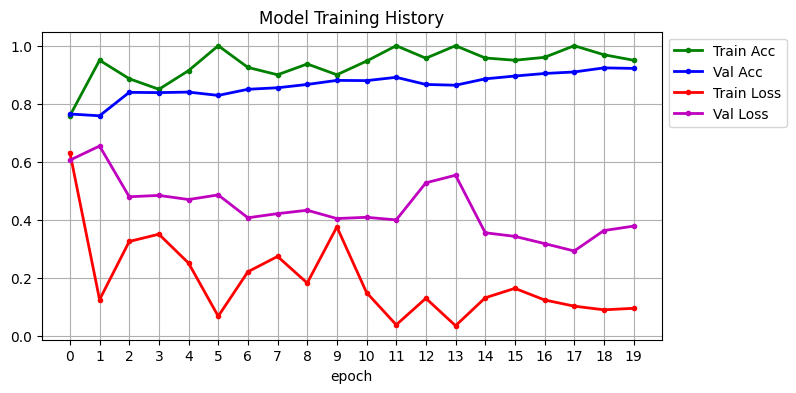

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       300
           1       0.93      0.88      0.91       306
           2       0.97      0.98      0.98       405
           3       0.94      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311

Confusion Matrix:
[[280  14   0   6]
 [ 10 270  12  14]
 [  4   4 397   0]
 [  3   1   0 296]]


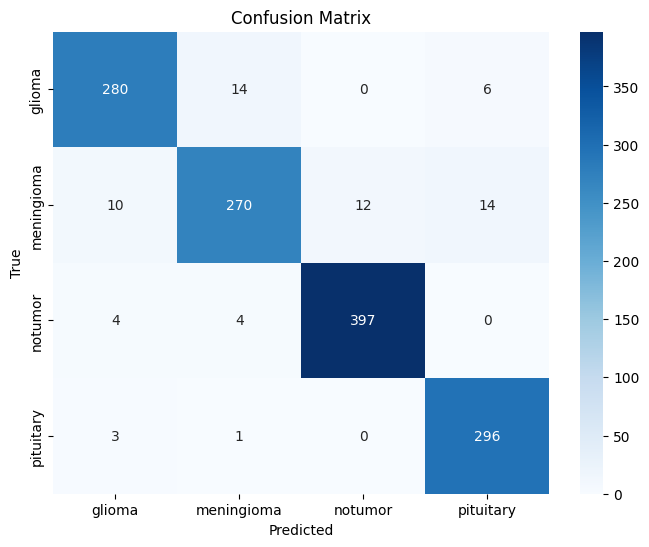

In [1]:
# -*- coding: utf-8 -*-
"""Brain_Tumor_CNN_Improved.ipynb"""

!pip install -q kagglehub
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Raw path:", path)

import os
data_root = None
for root, dirs, files in os.walk(path):
    if {"Training", "Testing"}.issubset(set(dirs)):
        data_root = root
        break

print("Data root:", data_root)
print("Train classes:", os.listdir(os.path.join(data_root, "Training")))
print("Test classes:", os.listdir(os.path.join(data_root, "Testing")))

train_dir = os.path.join(data_root, "Training")
test_dir = os.path.join(data_root, "Testing")

print("Train dir:", train_dir)
print("Test dir:", test_dir)

import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Collect train paths and labels (for class weights and visualization)
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for path in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, path))
        train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

# Display 10 random images (now at 224x224 for preview)
random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path).resize((224, 224))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {train_labels[idx]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Encode labels for class weights
unique_labels = sorted(os.listdir(train_dir))  # Sort for consistent order
train_labels_encoded = np.array([unique_labels.index(label) for label in train_labels])

# Compute class weights to handle imbalance
classes = np.unique(train_labels_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels_encoded)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# Data generators with improved augmentation
IMAGE_SIZE = 224
batch_size = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # New: small rotations
    width_shift_range=0.2,   # New: horizontal shifts
    height_shift_range=0.2,  # New: vertical shifts
    shear_range=0.2,         # New: shear
    zoom_range=0.2,          # New: zoom
    horizontal_flip=True,    # New: horizontal flips (safe for brain MRIs)
    brightness_range=[0.5, 1.5],  # Keep your original
    validation_split=0.2     # Split 20% of train for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

# Test generator (no augmentation, just rescale)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # For consistent evaluation
)

# Model: VGG16 with more unfrozen layers
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all but last 6 layers
for layer in base_model.layers[:-6]:
    layer.trainable = False

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))  # Slightly reduced to allow more learning
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train
epochs = 20  # Increased
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

# Plot history (now includes val)
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['val_accuracy'], '.b-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.plot(history.history['val_loss'], '.m-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks(range(epochs))
plt.legend(['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Evaluation on test
test_predictions = model.predict(test_generator)
test_labels_encoded = test_generator.classes  # From generator

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()